In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import multigrate as mtg
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# Read and prep data

In [3]:
adata = sc.read("../../../Volumes/Bee/data/haniffa-mil/adata_hvg.h5ad")
cite = sc.read("../../../Volumes/Bee/data/haniffa-mil/cite.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 21606 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'label'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [5]:
cite

AnnData object with n_obs × n_vars = 21606 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'label'
    var: 'feature_types'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [6]:
# have to specify the celltype column for the model for now, but will fix later
adata.obs['cell_type'] = adata.obs['initial_clustering']
cite.obs['cell_type'] = cite.obs['initial_clustering']

# Training the multigrate+MIL model end-to-end

Parameters:

```class_columns``` is the column in each .obs for the classificaiton labels

```bag_key``` indicates how to split adatas into bags

```condition``` if to have batch labels/conditions in modality encoders/decoders; here set to False as just one dataset, if set to True, the model gives each bag its own batch label

```z_dim``` = latent dimention

```hiddens``` specifies number of output dimentions for hidden layers in each modality encoder/decoder, e.g. ```hiddens = [[128], [64]]``` would mean input_dim_modality_1 -> 128 -> z_dim for encoder_modality_1 and input_dim_modality_1 -> 64 -> z_dim for encoder_modality_2; symmetric for decoders

```recon_coef``` is always set to 1

```kl_coef``` works best between 1e-7 and 1e-5

```integ_coef``` = MMD coeficient

```scoring``` = how to aggregate instances in a bag for classification, can be either 'attn', 'gated_attn' or 'sum'

```classifier_hiddens``` specifies number of layers and theit output dimentions for the MIL classifier, e.g. ```classifier_hiddens = [20, 20]``` would mean z_dim -> 20 -> 20 -> aggregation -> classification

In [7]:
model_mil = mtg.models.MultiVAE_MIL(
    adatas=[[adata], [cite]],
    names=[['rna'], ['cite']],
    class_columns = [['label'], ['label']],
    bag_key = 'patient_id',
    pair_groups=[['pair1'], ['pair1']],
    condition=False, # since just one dataset don't have batch labels, set to True if treating bags as different batches 
    z_dim=20, # latent dim
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=5e-6,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2,
    scoring='gated_attn',
    classifier_hiddens=[20]
)

Training parameters:

```n_iters``` number of iterations, good rule of thumb to set it to the max number of cells over bags if batch size = 64, or scale accordingly

```lr``` learning rate, 3e-4 works fine

```kl_anneal_iters``` usually set to 1/3 to 1/2 of n_iters

```validate_every``` usually set to 1/10 of n_iters

In [8]:
model_mil.train(
    n_iters=5000,
    #celltype_key='celltype.l1',
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=2500,
    validate_every=500
)

 |████████████████████| 100.0% iter=5000/5000, time=190.19(s), loss=0.6103, recon=0.6005, kl=234.9147, integ=0.8655, cycle=0.0000, val_loss=0.5806, val_recon=0.5705, val_kl=231.5603, val_integ=0.8944, val_cycle=0.0000

## viz losses

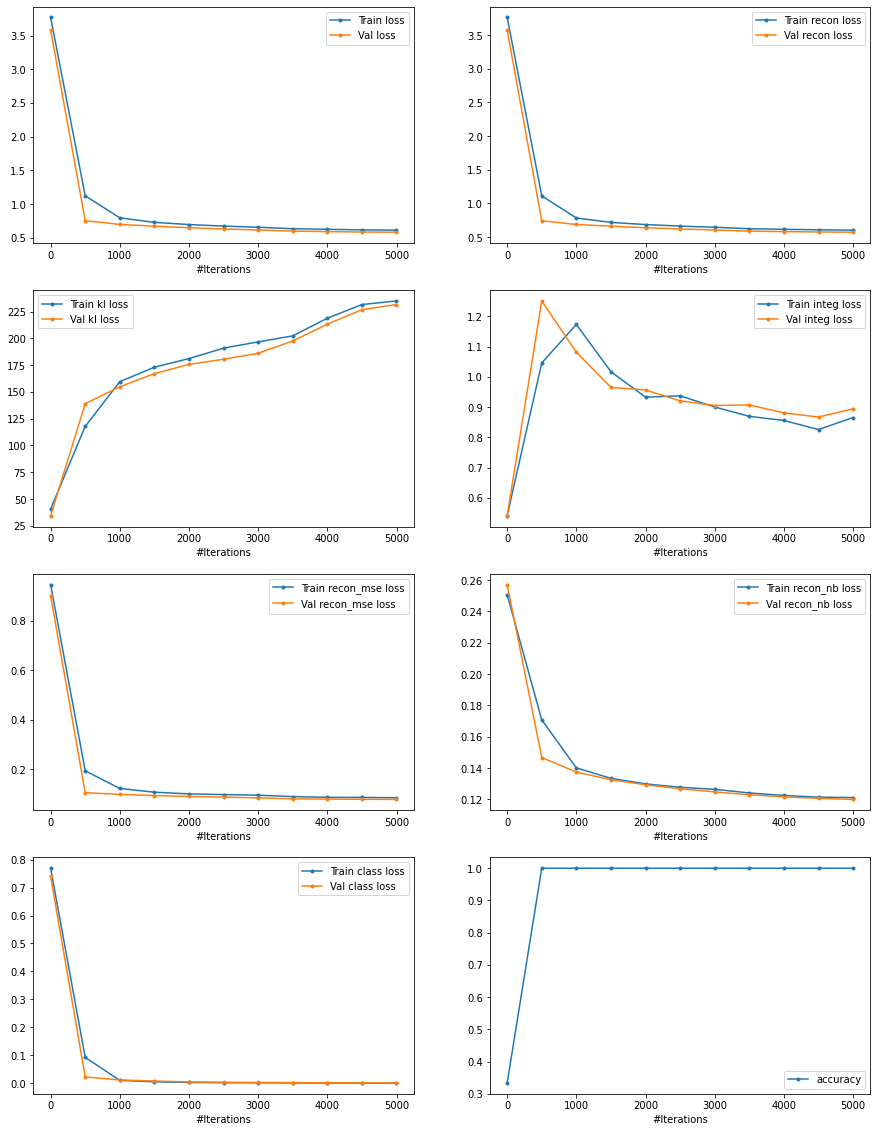

In [9]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_mse', 'recon_nb', 'class']
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model_mil.history['iteration'], model_mil.history['train_loss'], '.-', label='Train loss');
plt.plot(model_mil.history['iteration'], model_mil.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model_mil.history['iteration'], model_mil.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model_mil.history['iteration'], model_mil.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

plt.subplot(nrows, 2, nrows*2)
plt.plot(model_mil.history['iteration'], model_mil.history['accuracy'], '.-', label='accuracy');
plt.xlabel('#Iterations');
plt.legend()

## inference

In [10]:
out = model_mil.test(adatas=[[adata], [cite]], # same as before
    names=[['rna'], ['cite']], # only need for viz purposes
    pair_groups=[['pair1'], ['pair1']], # same as before
    layers=[['count'], [None]], # same as before
    batch_size=64,
)

In [11]:
integrated, classifier_adatas = out
integrated

AnnData object with n_obs × n_vars = 21606 × 20
    obs: 'modality', 'barcode', 'study', 'cell_type', 'predicted_label', 'attn_score', 'batch'

In [12]:
integrated

AnnData object with n_obs × n_vars = 21606 × 20
    obs: 'modality', 'barcode', 'study', 'cell_type', 'predicted_label', 'attn_score', 'batch'

In [13]:
# after each classifier layer, 0 = closest to the latent, last = closets to the aggregation
classifier_adatas

[AnnData object with n_obs × n_vars = 21606 × 20
     obs: 'modality', 'barcode', 'study', 'cell_type', 'batch']

## viz latent and classifier layers

In [15]:
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

... storing 'modality' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


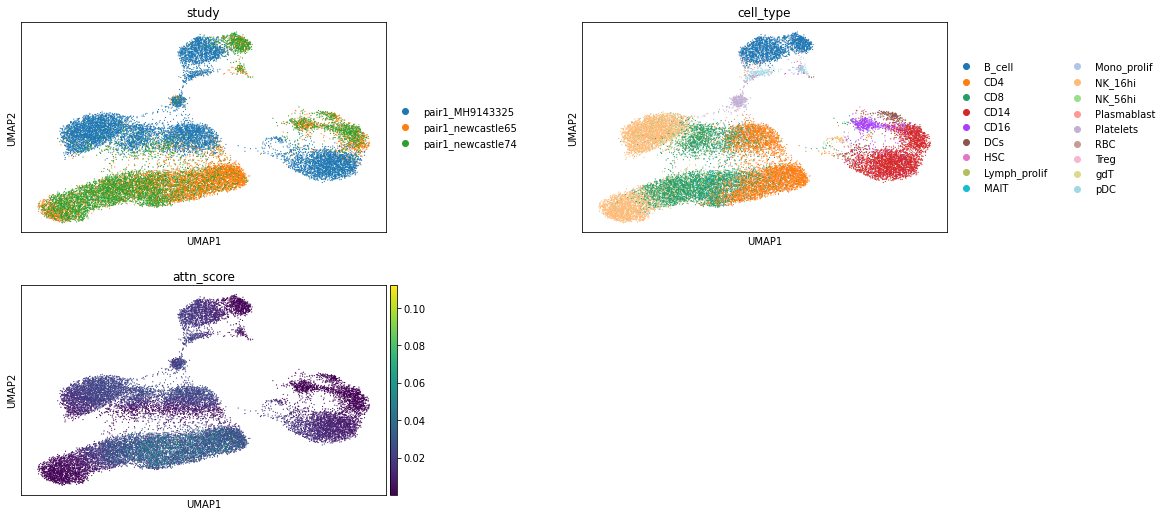

In [16]:
sc.pl.umap(integrated, color=['study', 'cell_type', 'attn_score'], ncols=2, wspace=0.4)

----- layer 0-----


... storing 'modality' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


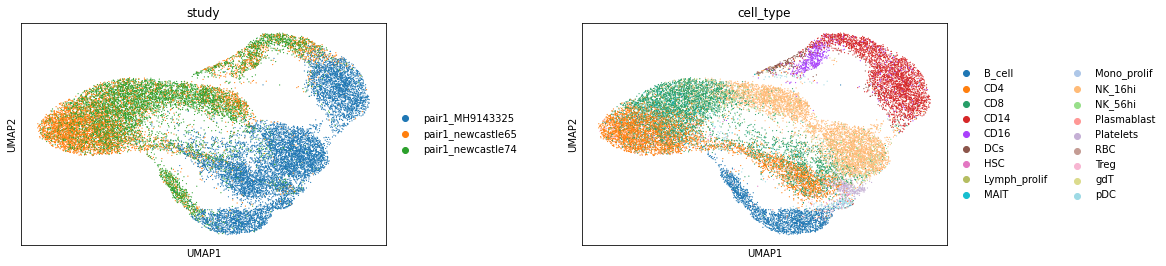

In [18]:
for i, adata_layer in enumerate(classifier_adatas):
    print(f"----- layer {i}-----")
    
    sc.pp.neighbors(adata_layer)
    sc.tl.umap(adata_layer)
    
    sc.pl.umap(adata_layer, color=['study', 'cell_type'], ncols=2, wspace=0.4)

# Pre-train multigrate model first, then fine-tune MIL model

In [21]:
# have to specify the celltype column for the model for now, but will fix later
adata.obs['cell_type'] = adata.obs['initial_clustering']
cite.obs['cell_type'] = cite.obs['initial_clustering']

In [22]:
model = mtg.models.MultiVAE_PoE_cond(
    adatas=[[adata], [cite]],
    names=[['rna'], ['cite']],
    pair_groups=[['pair1'], ['pair1']],
    condition=False, # here has to be set to False, otherwise later can't use the same model with MIL model!
    z_dim=20,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=5e-6,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2
)

In [23]:
model.train(
    n_iters=10000,
    #celltype_key='celltype.l1',
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=5000,
    validate_every=1000
)

 |████████████████████| 100.0% iter=10000/10000, time=94.08(s), loss=0.1912, recon=0.1907, kl=110.6346, integ=0.0000, cycle=0.0000, val_loss=0.1836, val_recon=0.1831, val_kl=104.0943, val_integ=0.0000, val_cycle=0.0000

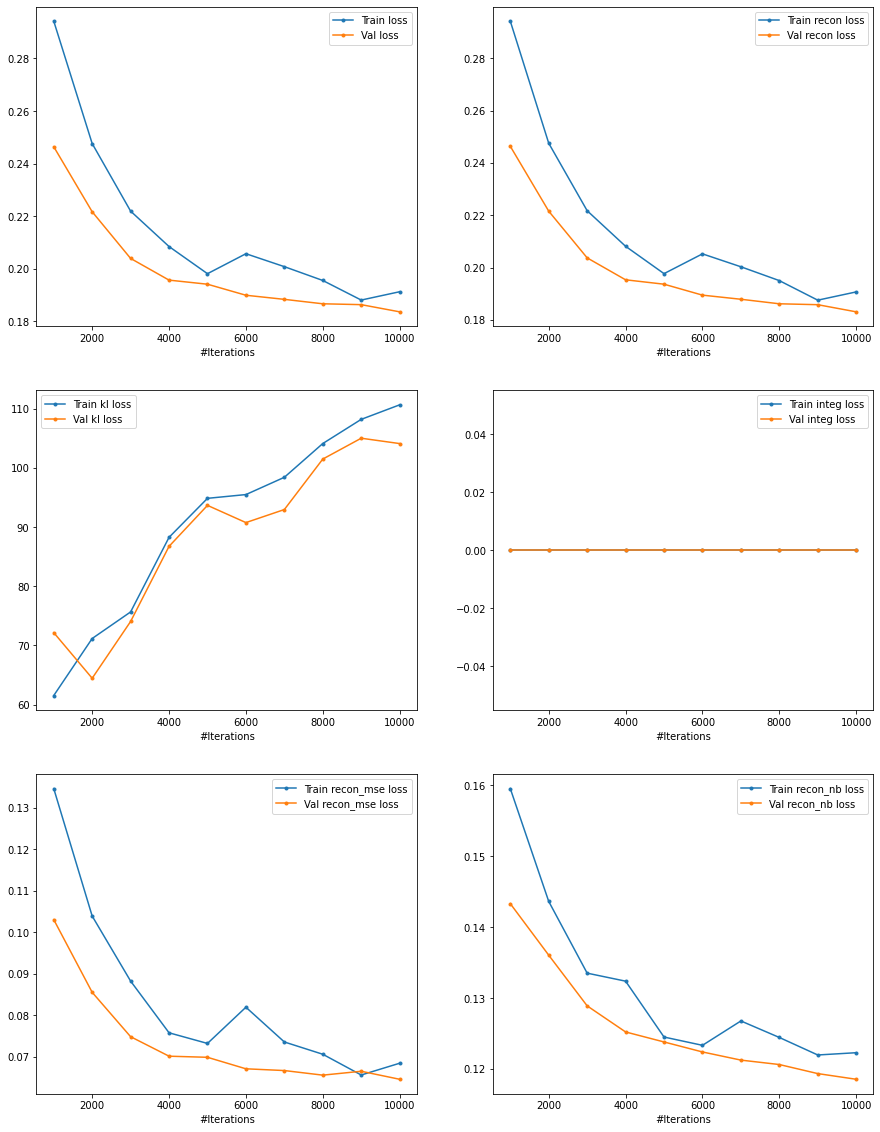

In [24]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_mse', 'recon_nb']
nrows = 3

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

In [25]:
# inference
out = model.test(adatas=[[adata], [cite]], # same as before
    names=[['rna'], ['cite']], # only need for viz purposes
    pair_groups=[['pair1'], ['pair1']], # same as before
    layers=[['count'], [None]], # same as before
    batch_size=64,
)

In [26]:
integrated = out[0]
integrated

AnnData object with n_obs × n_vars = 21606 × 20
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [27]:
integrated

AnnData object with n_obs × n_vars = 21606 × 20
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

## viz

In [29]:
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

... storing 'modality' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


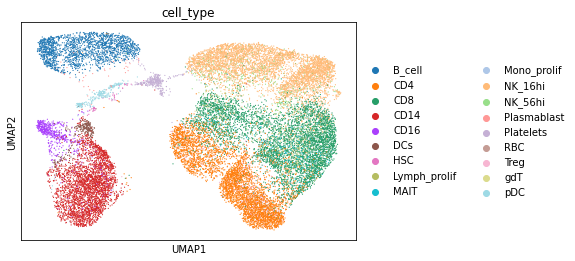

In [30]:
sc.pl.umap(integrated, color=['cell_type'], wspace=0.4)

## use the pre-trained model with MIL

In [33]:
# have to specify the celltype column for the model for now, but will fix later
adata.obs['cell_type'] = adata.obs['initial_clustering']
cite.obs['cell_type'] = cite.obs['initial_clustering']

In [34]:
model_mil = mtg.models.MultiVAE_MIL(
    adatas=[[adata], [cite]],
    names=[['rna'], ['cite']],
    class_columns = [['label'], ['label']],
    bag_key = 'patient_id',
    pair_groups=[['pair1'], ['pair1']], 
    condition=False, # has to be False!
    z_dim=20,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=5e-6,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2,
    scoring='gated_attn',
    classifier_hiddens=[20]
)

In [35]:
model_mil.use_model(model, freeze=True)

In [36]:
model_mil.train(
    n_iters=2000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=1000,
    validate_every=200
)

 |████████████████████| 100.0% iter=2000/2000, time=85.57(s), loss=0.6106, recon=0.6007, kl=326.7699, integ=0.8248, cycle=0.0000, val_loss=0.5723, val_recon=0.5611, val_kl=310.1377, val_integ=0.9715, val_cycle=0.0000

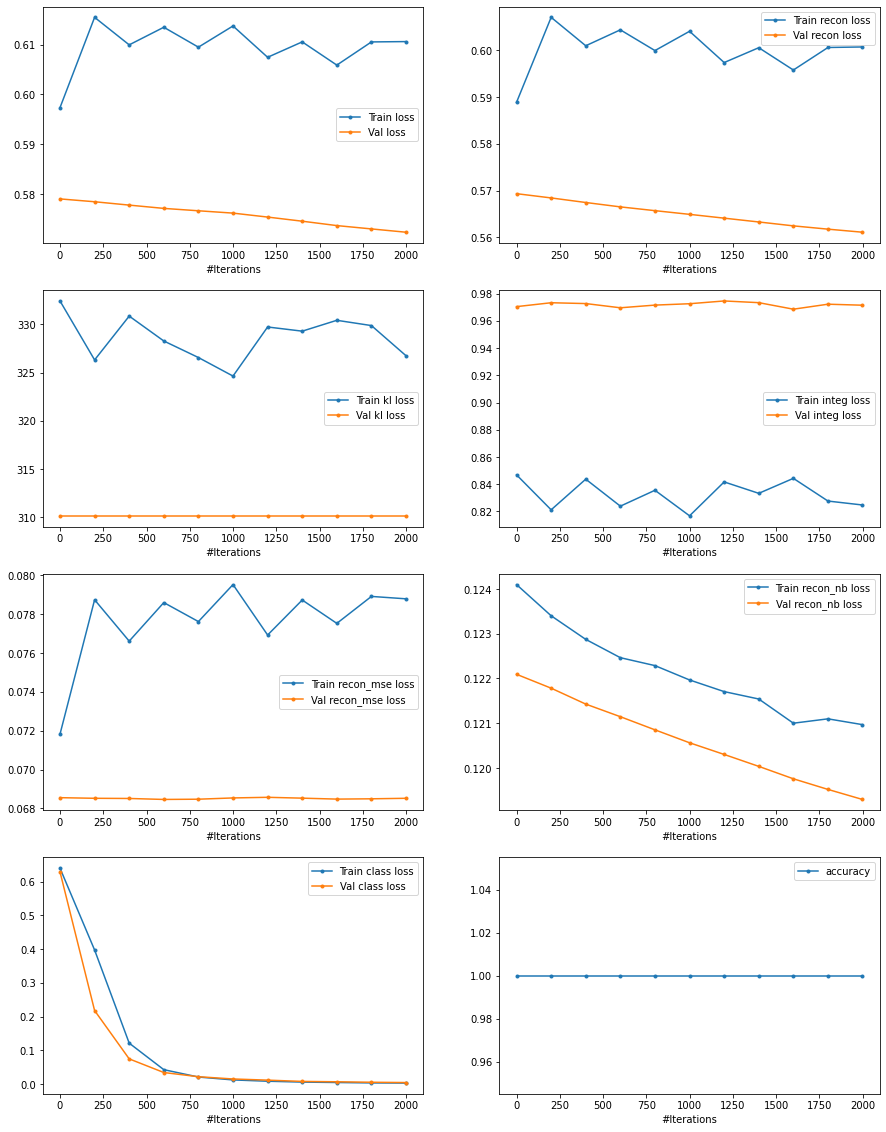

In [37]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_mse', 'recon_nb', 'class']
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model_mil.history['iteration'], model_mil.history['train_loss'], '.-', label='Train loss');
plt.plot(model_mil.history['iteration'], model_mil.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model_mil.history['iteration'], model_mil.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model_mil.history['iteration'], model_mil.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

plt.subplot(nrows, 2, nrows*2)
plt.plot(model_mil.history['iteration'], model_mil.history['accuracy'], '.-', label='accuracy');
plt.xlabel('#Iterations');
plt.legend()

In [38]:
out = model_mil.test(adatas=[[adata], [cite]],
    names=[['rna'], ['cite']],
    pair_groups=[['pair1'], ['pair1']],
    layers=[['count'], [None]],
    batch_size=64,
)

In [39]:
integrated, classifier_adatas = out
integrated

AnnData object with n_obs × n_vars = 21606 × 20
    obs: 'modality', 'barcode', 'study', 'cell_type', 'predicted_label', 'attn_score', 'batch'

In [40]:
classifier_adatas

[AnnData object with n_obs × n_vars = 21606 × 20
     obs: 'modality', 'barcode', 'study', 'cell_type', 'batch']

In [42]:
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

... storing 'modality' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


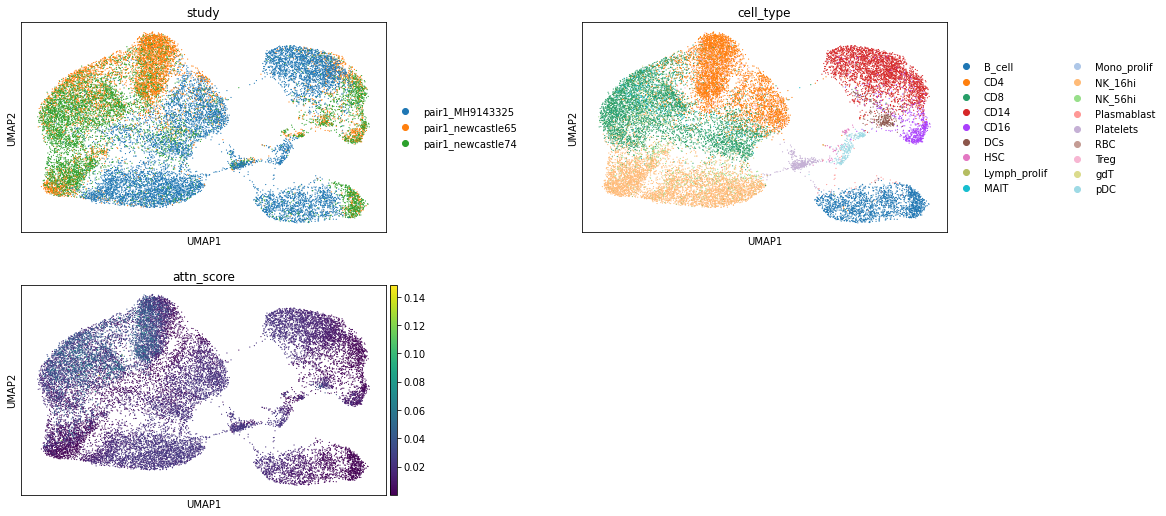

In [43]:
sc.pl.umap(integrated, color=['study', 'cell_type', 'attn_score'], ncols=2, wspace=0.4)

----- layer 0-----


... storing 'modality' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


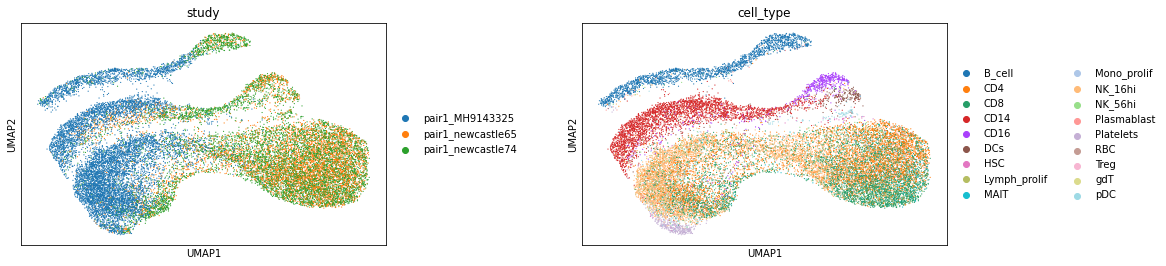

In [46]:
for i, adata_layer in enumerate(classifier_adatas):
    print(f"----- layer {i}-----")
    
    sc.pp.neighbors(adata_layer)
    sc.tl.umap(adata_layer)
    
    sc.pl.umap(adata_layer, color=['study', 'cell_type'], ncols=2, wspace=0.4)

# p.s. if need some data from the original adatas

In [ ]:
integrated.obs_names = integrated.obs.barcode

In [ ]:
integrated.obs = integrated.obs.join(adata.obs.label)

In [ ]:
sc.pl.umap(integrated, color=['study', 'cell_type', 'attn_score', 'label'], ncols=2, wspace=0.4)